In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
from itertools import combinations
import networkx as nx
import community
from utils.cluster import cluster
from utils.recombinations import recombinations
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pandas.io.formats.style import Styler
from utils.preprocessing import preprocessing
import os
import seaborn as sns
import igraph as ig
import scipy.stats as stats
import mplcursors
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from Bio.PDB import PDBParser, Selection, NeighborSearch
from numpy import linalg as LA
from Bio.SeqUtils import seq1

codontab = {
    'TCA': 'S',    # Serina
    'TCC': 'S',    # Serina
    'TCG': 'S',    # Serina
    'TCT': 'S',    # Serina
    'TTC': 'F',    # Fenilalanina
    'TTT': 'F',    # Fenilalanina
    'TTA': 'L',    # Leucina
    'TTG': 'L',    # Leucina
    'TAC': 'Y',    # Tirosina
    'TAT': 'Y',    # Tirosina
    'TAA': '*',    # Stop
    'TAG': '*',    # Stop
    'TGC': 'C',    # Cisteina
    'TGT': 'C',    # Cisteina
    'TGA': '*',    # Stop
    'TGG': 'W',    # Triptofano
    'CTA': 'L',    # Leucina
    'CTC': 'L',    # Leucina
    'CTG': 'L',    # Leucina
    'CTT': 'L',    # Leucina
    'CCA': 'P',    # Prolina
    'CCC': 'P',    # Prolina
    'CCG': 'P',    # Prolina
    'CCT': 'P',    # Prolina
    'CAC': 'H',    # Histidina
    'CAT': 'H',    # Histidina
    'CAA': 'Q',    # Glutamina
    'CAG': 'Q',    # Glutamina
    'CGA': 'R',    # Arginina
    'CGC': 'R',    # Arginina
    'CGG': 'R',    # Arginina
    'CGT': 'R',    # Arginina
    'ATA': 'I',    # Isoleucina
    'ATC': 'I',    # Isoleucina
    'ATT': 'I',    # Isoleucina
    'ATG': 'M',    # Methionina
    'ACA': 'T',    # Treonina
    'ACC': 'T',    # Treonina
    'ACG': 'T',    # Treonina
    'ACT': 'T',    # Treonina
    'AAC': 'N',    # Asparagina
    'AAT': 'N',    # Asparagina
    'AAA': 'K',    # Lisina
    'AAG': 'K',    # Lisina
    'AGC': 'S',    # Serina
    'AGT': 'S',    # Serina
    'AGA': 'R',    # Arginina
    'AGG': 'R',    # Arginina
    'GTA': 'V',    # Valina
    'GTC': 'V',    # Valina
    'GTG': 'V',    # Valina
    'GTT': 'V',    # Valina
    'GCA': 'A',    # Alanina
    'GCC': 'A',    # Alanina
    'GCG': 'A',    # Alanina
    'GCT': 'A',    # Alanina
    'GAC': 'D',    # Acido Aspartico
    'GAT': 'D',    # Acido Aspartico
    'GAA': 'E',    # Acido Glutamico
    'GAG': 'E',    # Acido Glutamico
    'GGA': 'G',    # Glicina
    'GGC': 'G',    # Glicina
    'GGG': 'G',    # Glicina
    'GGT': 'G'     # Glicina
}



In [149]:
path = '../Data/PDB structures/vh_match_100/'
df = pd.read_csv(os.path.join(path, 'vh_match_filtered.tsv'), sep='\t')
df = df.groupby('pdb').first()
df

,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
pdb,,,,,,,,,,,,,,,,,,,,,
2cmr,H,L,0.0,A,protein,None,transmembrane glycoprotein,IMMUNE SYSTEM,2005/11/06,Crystal structure of the HIV-1 neutralizing an...,...,False,True,IGHV1,IGKV1,Kappa,5.000000e-11,-14.04,SPR,25.0,16862157.0
2dd8,H,L,0.0,S,protein,None,spike glycoprotein,IMMUNE SYSTEM/VIRAL PROTEIN,01/24/06,Crystal Structure of SARS-CoV Spike Receptor-B...,...,False,True,IGHV1,IGLV3,Lambda,2.000000e-08,-10.50,SPR,25.0,16597622.0
2jb5,H,L,0.0,H,Hapten,T5C,"2-{(1E,3Z,5E,7E)-7-[3,3-DIMETHYL-5-SULFO-1-(2-...",IMMUNE SYSTEM,2012/03/06,Fab fragment in complex with small molecule ha...,...,False,True,IGHV1,IGLV2,Lambda,NaN,NaN,None,NaN,NaN
2jb6,B,A,0.0,B,Hapten,T5C,"2-{(1E,3Z,5E,7E)-7-[3,3-DIMETHYL-5-SULFO-1-(2-...",IMMUNE SYSTEM,2012/03/06,Fab fragment in complex with small molecule ha...,...,False,True,IGHV1,IGLV2,Lambda,NaN,NaN,None,NaN,NaN
2xtj,D,B,0.0,A,protein,None,proprotein convertase subtilisin/kexin type 9,HYDROLASE/ANTIBODY,2010/10/10,The crystal structure of PCSK9 in complex with...,...,False,True,IGHV1,IGKV1D,Kappa,4.400000e-09,-11.39,SPR,25.0,20959675.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7wqv,B,B,0.0,A,protein,None,spike protein s1,VIRAL PROTEIN,01/25/23,Crystal structure of a neutralizing monoclonal...,...,True,True,unknown,unknown,unknown,NaN,NaN,None,NaN,NaN
7y0c,A,B,0.0,R,protein,None,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,09/28/22,Crystal structure of BD55-1403 and SARS-CoV-2 ...,...,False,True,IGHV1,IGKV3,Kappa,NaN,NaN,None,NaN,NaN
7ytn,H,L,0.0,C,protein,None,spike protein s1,ANTIVIRAL PROTEIN/VIRAL PROTEIN,06/28/23,Crystal structure of SARS-CoV-2 Alpha RBD in c...,...,False,True,IGHV1,IGLV3,Lambda,NaN,NaN,None,NaN,NaN


In [234]:
mindis = defaultdict(list)
for pdb in os.listdir(os.path.join(path, 'chothia')):
    pdb_name = pdb.split('.')[0]
    if pdb_name in df.index:
        # Load the PDB file
        pdb_parser = PDBParser(QUIET=True)
        structure = pdb_parser.get_structure(pdb_name, os.path.join(path, 'chothia', pdb))

        # Initialize lists to store residue numbers and minimum distances
        residue_numbers = []
        min_distances = []

        # Define the chains of interest (A and D)
        chain_a = structure[0][df.loc[pdb_name, 'antigen_chain'].split(' |')[0]]
        chain_h = structure[0][df.loc[pdb_name, 'Hchain']]

        #Create a NeighborSearch object for chain A
        #ns = NeighborSearch(list(chain_a.get_atoms()))
        id_temp = ''
        id_overlap = 0
        # Iterate through residues in chain D
        for i, residue_h in enumerate(chain_h):
            min_distance = float('inf')
            for atom_h in residue_h:
                for atom_a in chain_a.get_atoms():
                    distance = atom_a - atom_h
                    if distance < min_distance:
                        min_distance = distance
            numeric_part = ""
            for char in id_temp:
                if char.isdigit():
                    numeric_part += char
                else:
                    break
            if numeric_part == str(residue_h.id[1]):
                id_overlap+=1
                id_temp = str(residue_h.id[1]) + chr(ord('A') + id_overlap - 1)
            if numeric_part != str(residue_h.id[1]):
                id_overlap = 0
                id_temp = str(residue_h.id[1])
            residue_numbers.append(f'{seq1(residue_h.get_resname())}({id_temp})')  # Get the residue number
            min_distances.append(min_distance)

        for d, r in zip(min_distances, residue_numbers):
            mindis[pdb_name].append([d, r])

        # # Plot the minimum distances
        # plt.figure(figsize=(10, 6))
        #
        # plt.plot(residue_numbers, min_distances, marker='', linestyle='-', color='skyblue', linewidth=1)
        # plt.xlabel('Amino Acids (Residue Number)`')
        # plt.ylabel('Minimum Distance (Å)')
        # plt.title(f'Antigen-VH distances, {structure.get_id()}')
        # plt.grid(True)
        # plt.xticks(rotation=90, fontsize=3)
        # plt.tight_layout()
        # plt.savefig(f'../Data/Figures/vh_antigen_distances/Antigen-VH distances, {structure.get_id()}.png', dpi=500)
        # plt.close()

In [235]:
for pdb_id in mindis:


defaultdict(list,
            {'6yio': [[6.9222383, 'Q(1)'],
              [6.44638, 'V(2)'],
              [10.903155, 'Q(3)'],
              [11.644306, 'L(4)'],
              [15.574076, 'V(5)'],
              [17.699059, 'Q(6)'],
              [20.164724, 'S(7)'],
              [23.32721, 'G(8)'],
              [26.805151, 'A(9)'],
              [24.241858, 'E(10)'],
              [30.548065, 'V(11)'],
              [26.859823, 'K(12)'],
              [32.264442, 'K(13)'],
              [33.295895, 'P(14)'],
              [29.40504, 'G(15)'],
              [28.019178, 'S(16)'],
              [24.726917, 'S(17)'],
              [22.325098, 'V(18)'],
              [16.061611, 'K(19)'],
              [17.94819, 'V(20)'],
              [16.674381, 'S(21)'],
              [13.2142105, 'C(22)'],
              [12.617768, 'K(23)'],
              [9.638993, 'A(24)'],
              [10.811715, 'S(25)'],
              [8.182789, 'G(26)'],
              [6.6336184, 'G(27)'],
              [4.

In [233]:
for a, b in mindis['6mf1']:
    print(b)

In [120]:
distance_map = {}
for residue, distance in zip(residue_numbers, min_distances):
    distance_map[residue] = distance
distance_map = {k: v for k, v in sorted(distance_map.items(), key=lambda item: item[1])}
distance_map

{'T(104)': 2.8857758,
 'X(221)': 2.9550369,
 'X(217)': 3.0460534,
 'X(224)': 3.1239731,
 'G(103)': 3.1494544,
 'N(58)': 3.154694,
 'A(102)': 3.1966221,
 'P(32)': 3.2748814,
 'L(53)': 3.4125168,
 'P(105)': 3.4158182,
 'G(49)': 3.428534,
 'F(54)': 3.4972384,
 'S(30)': 3.5420017,
 'S(34)': 3.68075,
 'S(101)': 3.6900985,
 'W(46)': 3.807503,
 'I(51)': 3.8180585,
 'I(50)': 4.1228833,
 'T(56)': 4.6568007,
 'D(106)': 4.6748595,
 'G(48)': 4.747161,
 'I(33)': 4.893689,
 'S(29)': 4.910901,
 'Y(31)': 5.314628,
 'Q(64)': 5.4684296,
 'A(57)': 5.8908596,
 'A(100)': 6.115586,
 'Y(59)': 6.146867,
 'F(108)': 6.2194276,
 'E(73)': 6.569248,
 'G(55)': 6.7199616,
 'W(35)': 6.829499,
 'P(52)': 7.1133246,
 'Y(107)': 7.5369244,
 'I(69)': 7.6026397,
 'V(47)': 7.826122,
 'A(96)': 7.8302517,
 'F(28)': 7.8347416,
 'A(60)': 7.968855,
 'Q(61)': 8.158921,
 'G(98)': 8.242974,
 'T(27)': 8.751731,
 'I(99)': 8.815899,
 'R(97)': 9.139857,
 'V(36)': 9.188319,
 'X(229)': 9.527315,
 'X(223)': 10.5369625,
 'R(62)': 10.753707,

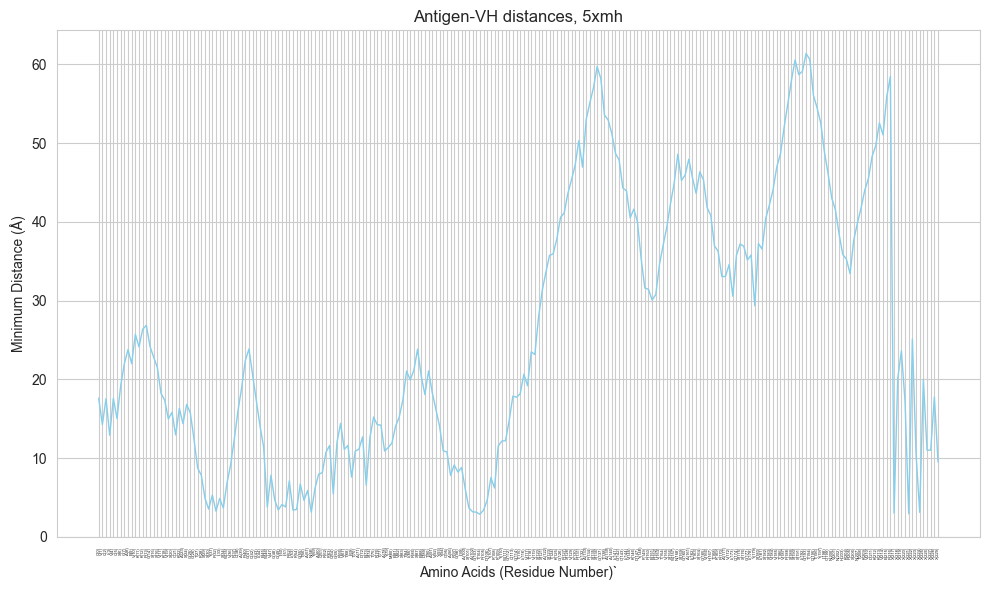

In [108]:
# Plot the minimum distances
plt.figure(figsize=(10, 6))

plt.plot(residue_numbers, min_distances, marker='', linestyle='-', color='skyblue', linewidth=1)
plt.xlabel('Amino Acids (Residue Number)`')
plt.ylabel('Minimum Distance (Å)')
plt.title(f'Antigen-VH distances, {structure.get_id()}')
plt.grid(True)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()
plt.savefig(f'../Data/Figures/Antigen-VH distances, {structure.get_id()}.png', dpi=500)
plt.show()